In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
# Импорт библиотек
import numpy as np # для работы с массивами
import pandas as pd # для работы с DataFrame
import seaborn as sns # библиотека для визуализации статистических данных
import matplotlib.pyplot as plt # для построения графиков
import re # для регулярных выражений
import json # для десериализации

%matplotlib inline

In [36]:
data = pd.read_csv('/content/drive/My Drive/final_project/data 2.csv')

# 1. Проведение разведывательного анализа и очистка исходных данных

Посмотрим на столбцы, содержащиеся в данных

In [37]:
data.columns

Index(['status', 'private pool', 'propertyType', 'street', 'baths',
       'homeFacts', 'fireplace', 'city', 'schools', 'sqft', 'zipcode', 'beds',
       'state', 'stories', 'mls-id', 'PrivatePool', 'MlsId', 'target'],
      dtype='object')

Исходя из названий столбцов видим, что у нас есть дублирующиеся названия колонок, которые нужно соединить воедино ("private pool" + "PrivatePool", "mls-id" + "MlsId")

In [38]:
# Создаем новый столбец на основе "private pool", заполняя nan значениями из "PrivatePool"
data['privatePool'] = data['private pool'].fillna(data['PrivatePool'])
# Удаляем использованные столбцы
data = data.drop(columns=['private pool', 'PrivatePool'])

# Создаем новый столбец на основе "mls-id", заполняя nan значениями из "MlsId"
data['mlsId'] = data['mls-id'].fillna(data['MlsId'])
# Удаляем использованные столбцы
data = data.drop(columns=['mls-id', 'MlsId'])

In [39]:
data['privatePool'].unique()

array([nan, 'yes', 'Yes'], dtype=object)

Бинаризируем значения

In [40]:
data['privatePool'] = data['privatePool'].apply(lambda x: 1 if x == 'yes' else 0)

In [41]:
data['privatePool'].unique()

array([0, 1])

Убедимся в том, что замена произошла успешно

In [42]:
data.columns

Index(['status', 'propertyType', 'street', 'baths', 'homeFacts', 'fireplace',
       'city', 'schools', 'sqft', 'zipcode', 'beds', 'state', 'stories',
       'target', 'privatePool', 'mlsId'],
      dtype='object')

# Столбец Status

Для приведения к консинстентному виду мы должны все привести к следующим названиям:
1. foreclosed
2. pre foreclosure
3. under contract showing
4. under contract backups
5. contingency
6. contingency contract
7. active contingency
8. insp inspection contingency
9. pending escape clause
10. pending backup wanted
11. pending take backups
12. pending continue show
13. pending inspection
14. due diligence period
15. activated
16. active with contract
17. active with offer
18. active auction
19. cooling-off period

В столбце есть дубликаты, их заменой мы займемся ниже, предварительно приведя текст к нижнему регистру и удалив лишние пробелы

In [43]:
data['status'] = data['status'].str.lower().str.strip()

Далее начнем заменять дубликаты:

In [44]:
# under contract showing
data['status'] = data['status'].replace('under contract   showing', 'under contract showing')
data['status'] = data['status'].replace('active under contract', 'under contract showing')
data['status'] = data['status'].replace('under contract', 'under contract showing')
data['status'] = data['status'].replace('under contract show', 'under contract showing')
data['status'] = data['status'].replace('under contract showinging', 'under contract showing')
data['status'] = data['status'].replace('under contract showinging showing', 'under contract showing')
data['status'] = data['status'].replace('under contract showing showing', 'under contract showing')
data['status'] = data['status'].replace('under contract showing show', 'under contract showing')
data['status'] = data['status'].replace('u under contract', 'under contract showing')
# pre foreclosure
data['status'] = data['status'].replace('pre-foreclosure', 'pre foreclosure')
data['status'] = data['status'].replace('pre-foreclosure / auction', 'pre foreclosure')
data['status'] = data['status'].replace('/ auction', 'pre foreclosure')
data['status'] = data['status'].replace('pre foreclosure pre foreclosure', 'pre foreclosure')
data['status'] = data['status'].replace('pre foreclosure auction', 'pre foreclosure')
data['status'] = data['status'].replace('pf', 'pre foreclosure')
# foreclosed
data['status'] = data['status'].replace('foreclosure', 'foreclosed')
# under contract backups
data['status'] = data['status'].replace('active backup', 'under contract backups')
data['status'] = data['status'].replace('backup contract', 'under contract backups')
data['status'] = data['status'].replace('accepting backups', 'under contract backups')
data['status'] = data['status'].replace('under contract w/ bckp', 'under contract backups')
data['status'] = data['status'].replace('under contract taking back up offers', 'under contract backups')
# active auction
data['status'] = data['status'].replace('auction active', 'active auction')
data['status'] = data['status'].replace('auction', 'active auction')
data['status'] = data['status'].replace('auction - active', 'active auction')
data['status'] = data['status'].replace('a active', 'active auction')
# pending continue show
data['status'] = data['status'].replace('pending   continue to show', 'pending continue show')
data['status'] = data['status'].replace('pending continue to show', 'pending continue show')
data['status'] = data['status'].replace('c continue show', 'pending continue show')
data['status'] = data['status'].replace('pending   continue to show   financing', 'pending continue show')
# coming soon: ...
data['status'] = data['status'].replace(r'^coming soon:.*$', 'coming soon', regex=True)
# activated
data['status'] = data['status'].replace('active', 'activated')
# contingency
data['status'] = data['status'].replace('c', 'contingency')
data['status'] = data['status'].replace('contingency 48 hr (+/ )', 'contingency')
# active contingency
data['status'] = data['status'].replace('active contingent', 'active contingency')
# pending inspection
data['status'] = data['status'].replace('pi', 'pending inspection')
# for rent
data['status'] = data['status'].replace('apartment for rent', 'for rent')
data['status'] = data['status'].replace('condo for rent', 'for rent')
# contingency contract
data['status'] = data['status'].replace('contract contingent on buyer sale', 'contingency contract')
# pending take backups
data['status'] = data['status'].replace('pending bring backup', 'pending take backups')
data['status'] = data['status'].replace('pending taking backups', 'pending take backups')
# pending escape clause
data['status'] = data['status'].replace('pending w/escape clause', 'pending escape clause')
# pending backup wanted
data['status'] = data['status'].replace('pending w/backup wanted', 'pending backup wanted')
data['status'] = data['status'].replace('pending backups wanted', 'pending backup wanted')
# active contingency
data['status'] = data['status'].replace('active/contingent', 'active contingency')
data['status'] = data['status'].replace('active with contingencies', 'active contingency')
# contingency
data['status'] = data['status'].replace('contingent', 'contingency')
# insp inspection contingency
data['status'] = data['status'].replace('contingent finance and inspection', 'insp inspection contingency')
# new construction
data['status'] = data['status'].replace('new', 'new construction')

# удаляем строки с пропущенным значением
# data = data.dropna(subset=['status'])

# заменяем пустые значения на "активный"
data['status'].fillna('activated', inplace=True)

# удаляем неявные столбцы:
data = data.loc[~data['status'].isin(
    [
        'pending', 'p', 'option pending',
        'p pending sale', 'pending ab',
        'contingent show', 'contract p',
        'contingent take backup',
        'option contract', 'pending continue show',
        'contingent   show',
        'pending with contingencies', 'lease/purchase pending',
        'offer pending signature', 'contingent lien holder release',
        'price change', 'contingent escape', 'pending offer approval',
        'pending in', 'ct', 'pending w/insp finance', 'temporary active',
        'pending (do not show)', 'pending w/ cont.', 'contingent   release',
        'accepted offer', 'contingent   no show', 'pending sale',
        'contingent   foreclosure', 'conting accpt backups',
        'lease/purchase', 'sold: $285,000', 'sold: $15,000',
        'ps', 're activated', 'uc continue to show', 'pending sh',
        'pending fe'
    ]
)]

In [45]:
data['status'].unique()

array(['activated', 'for sale', 'new construction', 'active contingency',
       'pre foreclosure', 'under contract showing',
       'under contract backups', 'foreclosed', 'for rent',
       'active auction', 'contingency', 'back on market', 'active option',
       'recently sold', 'coming soon', 'insp inspection contingency',
       'pending inspection', 'active option contract',
       'due diligence period', 'contingency contract',
       'pending take backups', 'under contract - show',
       'active - auction', 'active with offer', 'closed',
       'listing extended', 'pending, continue to show',
       'pending - taking backups', 'ct insp - inspection contingency',
       'pending escape clause', 'pending - continue to show',
       'under contract - no show', 'contract', 'conditional contract',
       'active - contingent', 'active with contract',
       'pending backup wanted', 'contingent - sale of home',
       'pending - backup offer requested', 'reactivated',
       'conti

# Столбец propertyType

Приведем столбец изначально к нижнему регистру

Должны получить следующие типы домов:
1. apartment
2. condo
3. co-op
4. single-family
5. townhome, townhouse
6. cape cod
7. colonial home
8. contemporary
9. cottage
10. craftsman
11. greek revival
12. farmhouse
13. french country
14. mediterranean
15. midcentury modern
16. ranch
17. split-level
18. tudor
19. victorian
20. european houses style
21. log home

In [46]:
data[data['propertyType'].isna()]

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,privatePool,mlsId
7,activated,NaN,6094 Mingle Dr,NaN,"{'atAGlanceFacts': [{'factValue': '1976', 'fac...",NaN,Memphis,"[{'rating': ['4', '2', '2'], 'data': {'Distanc...",NaN,38115,NaN,TN,NaN,"68,000",0,10063506
16,activated,NaN,2402 NW 22nd Rd,"1,750","{'atAGlanceFacts': [{'factValue': '2008', 'fac...",NaN,Fort Lauderdale,"[{'rating': ['4', 'NR', '3', 'NR'], 'data': {'...","2,203",33311,Baths,FL,NaN,"335,000",0,F10207914
26,activated,NaN,5755 SW 123 Ave,"1,000","{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Miami,"[{'rating': ['9', '10', 'NR', '6', '3'], 'data...",NaN,33183,Baths,FL,NaN,"799,000",0,A10787617
40,activated,NaN,1104 Rotonda Cir,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,ROTONDA WEST,"[{'rating': ['6', '6', '7'], 'data': {'Distanc...",NaN,33947,NaN,FL,NaN,"54,000",0,D6107075
42,activated,NaN,MLS #: STRI1057289,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,New York,"[{'rating': ['NR', 'NR', '9', '8', '8', '2', '...",NaN,10006,NaN,NY,NaN,"850,000",0,STRI1057289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377141,activated,NaN,Mantova Ct,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,ORLANDO,"[{'rating': ['7', '6', 'NR', 'NR', '7'], 'data...",NaN,32836,NaN,FL,NaN,"400,000",0,O5763033
377143,activated,NaN,3500 Coral Way #410,NaN,"{'atAGlanceFacts': [{'factValue': '2002', 'fac...",NaN,Miami,"[{'rating': ['7', 'NR', '10', '5', '5'], 'data...",842,33145,NaN,FL,NaN,"299,000",0,A10768308
377144,activated,NaN,1212 Laurel St Apt 401,NaN,"{'atAGlanceFacts': [{'factValue': '2014', 'fac...",NaN,Nashville,"[{'rating': ['1', '3', '2', '8', '3', '1'], 'd...",908,37203,NaN,TN,NaN,"530,000",0,2097877
377154,activated,NaN,2104 Russell Ave,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Charlotte,"[{'rating': ['2', '3', '3'], 'data': {'Distanc...",NaN,28216,NaN,NC,NaN,"99,990",0,3571015


In [47]:
data['propertyType'].nunique()

1270

In [48]:
data['propertyType'] = data['propertyType'].str.lower()

# удаляем строки с пропущенным значением
# data = data.dropna(subset=['propertyType'])

In [49]:
# Определяем функцию для обработки значений
def clean_property_type(value):
    if pd.isna(value):
      return np.nan
    # Используем .lower() для обеспечения однообразия (все символы в нижнем регистре)
    value = value.lower().strip()

    # Обработка дублирований
    if '/' in value:
      return 'miscellaneous'
    elif 'single family' in value or 'single-family' in value or 'detached' in value or 'tiny' in value:
        return 'single-family home'
    elif 'mobile' in value or 'manufactured' in value or 'prefab' in value or 'modular' in value or 'mo2 le' in value or 'mo2le' in value:
        return 'manufactured home (house)'
    elif 'cabin' in value or 'ca2 n' in value or 'ca2n' in value:
        return 'cabin'
    elif 'midcentury' in value or 'mid century' in value:
        return 'mid-century'
    elif 'multi family' in value or 'multi-family' in value:
        return 'multi-family home'
    elif 'coop' in value:
      return 'co-op'
    elif 'cape' in value or 'cod' in value:
      return 'cape cod'
    elif 'colonial' in value:
      return 'colonial home'
    elif 'contemporary' in value:
      return 'contemporary'
    elif 'cottage' in value:
      return 'cottage'
    elif 'greek' in value or 'revival' in value:
      return 'greek revival'
    elif 'farmhouse' in value:
      return 'farmhouse'
    elif 'french' in value:
      return 'french country'
    elif 'mediterranean' in value:
      return 'mediterranean'
    elif 'ranch' in value:
      return 'ranch'
    elif 'split' in value or 'level' in value:
      return 'split-level'
    elif 'tudor' in value:
      return 'tudor'
    elif 'victorian' in value or 'queen' in value:
      return 'victorian'
    elif 'european' in value:
      return 'european houses style'
    elif 'log' in value:
      return 'log home'
    elif 'apartment' in value:
      return 'apartment'
    elif 'condo' in value:
      return 'condo'
    elif 'townhome' in value or 'townhouse' in value:
      return 'townhome'
    elif 'land' in value:
      return 'land'
    elif 'traditional' in value or 'story' in value or 'stories' in value:
      return 'land'
    elif 'transitional' in value:
      return 'transitional'
    elif 'florida' in value:
      return 'florida'
    elif 'bungalow' in value:
      return 'bungalow'
    elif 'garden' in value:
      return 'garden home'
    elif 'other' in value or 'custom' in value or 'unknown' in value:
      return 'other'
    elif 'craftsman' in value:
      return 'craftsman'
    elif 'occupancy' in value:
      return 'multiple occupancy'
    elif 'cluster home' in value:
      return 'cluster home'
    elif 'federal' in value:
      return 'federal'
    else:
        # Если не соответствует ни одному из вышеуказанных, возвращаем исходное значение
        return 'other'

# Применяем функцию к столбцу 'propertyType'
data['propertyType'] = data['propertyType'].apply(clean_property_type)

In [50]:
data['propertyType'].value_counts()

single-family home           187097
condo                         42549
miscellaneous                 34507
land                          20576
townhome                      18499
multi-family home             11982
other                          4319
co-op                          3796
contemporary                   2422
ranch                          2374
colonial home                  1314
apartment                       939
split-level                     716
florida                         615
transitional                    592
bungalow                        478
cape cod                        407
garden home                     336
mediterranean                   235
craftsman                       208
multiple occupancy              158
cluster home                    123
federal                         119
victorian                       118
french country                  112
manufactured home (house)        84
tudor                            78
cottage                     

# Столбец street

По идеи полезной информации для модели не несёт

In [51]:
# в принципе не особо нужный столбец
data['street'].unique()

array(['240 Heather Ln', '12911 E Heroy Ave', '2005 Westridge Rd', ...,
       '15509 Linden Blvd', '7810 Pereida St', '5983 Midcrown Dr'],
      dtype=object)

# Столбец baths

Нужно очистись столбец от любых слов и символов, оставиви только числа

In [52]:
# Заменяем запятые на точки
data['cleaned_baths'] = data['baths'].str.replace(',', '.')

# Оставляем только цифры и точки
data['cleaned_baths'] = data['cleaned_baths'].str.replace('[^0-9/\- .]', '').str.strip()

# Заменяем значения без чисел на np.nan
mask = data['cleaned_baths'].str.contains(r'\d', na=False)
data.loc[~mask, 'cleaned_baths'] = np.nan

# Замена NaN значений на какое-либо уместное значение или удаление
data['cleaned_baths'].fillna(value=0, inplace=True)

<ipython-input-52-7368de0e8ffc>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  data['cleaned_baths'] = data['cleaned_baths'].str.replace('[^0-9/\- .]', '').str.strip()


In [53]:
data['cleaned_baths'].unique()

array(['3.5', '3', '2', '8', 0, '1.750', '4', '5', '1.000', '7', '2.0',
       '3.0', '1', '4.0', '2.1', '2.5', '4.5', '6', '2.500', '5.5', '1.0',
       '1.5', '4.000', '2.000', '3.000', '8.0', '5.0', '1.500', '7.0',
       '1.250', '9', '2.250', '0', '6.0', '12', '3.500', '2.750', '750',
       '10', '19', '10.0', '7.5', '0 / 0', '18', '11', '5.000', '1.75',
       '12.0', '1.1', '6.5', '16', '13', '14', '9.0', '8.5', '17', '241',
       '16.0', '10.5', '7.500', '11.0', '20', '40', '1-0 / 1-0 / 1',
       '14.0', '2.75', '24', '22.0', '0.00', '2.25', '3.1', '3.25', '22',
       '32', '18.0', '0.0', '27', '26', '20.0', '9.5', '15', '3.75', '29',
       '116 / 116 / 116', '21', '5.2', '14.5', '76', '13.0', '3-1 / 2-2',
       '15.0', '23', '3.3', '43', '1.25', '34', '2.2', '1 / 1 / 1 / 1',
       '55.0', '25', '12.5', '44', '0.5', '4.25', '4.75', '0.75', '4.1',
       '5.25', '41.0', '1.8', '36', '30', '24.0', '23.0', '28', '2.8',
       '34.0', '64.0', '11.5', '39', '30.0', '17.0', '4

Избавимся от крайних значений

In [54]:
# Удаление строк, содержащих символ "/"
data = data[~data['cleaned_baths'].str.contains('/', na=False)]
data = data[~data['cleaned_baths'].str.contains('-', na=False)]

# Преобразование в float
data['cleaned_baths'] = data['cleaned_baths'].astype(float)

# Округление значений
data['cleaned_baths'] = data['cleaned_baths'].round()

# Удаление значений больше 15
data = data[data['cleaned_baths'] <= 15]

# Преобразование в int
data['cleaned_baths'] = data['cleaned_baths'].astype(int)


<ipython-input-54-2fb23bcb30f4>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cleaned_baths'] = data['cleaned_baths'].astype(int)


In [55]:
data['cleaned_baths'].unique()

array([ 4,  3,  2,  8,  0,  5,  1,  7,  6,  9, 12, 10, 11, 13, 14, 15])

# Столбец homeFacts

Для его обработки нужно предварительно десериализовать данные, что поможет, к тому же, создать новые призанки

In [56]:
data['homeFacts'][0]

"{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}]}"

In [57]:
import ast
import pandas as pd

# 1. Десериализация
data['homeFacts_deserialized'] = data['homeFacts'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else {})

# 2. Преобразование atAGlanceFacts в словарь
def extract_facts(facts_dict):
    facts = facts_dict.get('atAGlanceFacts', [])
    return {item['factLabel']: item['factValue'] for item in facts}

data['homeFacts_extracted'] = data['homeFacts_deserialized'].apply(extract_facts)

# 3. Преобразование словарей в DataFrame
new_facts_df = pd.DataFrame(data['homeFacts_extracted'].tolist())

# 4. Добавление новых столбцов в исходный DataFrame
data = pd.concat([data, new_facts_df], axis=1)

# Удаляем ненужные столбцы
data.drop(columns=['homeFacts', 'homeFacts_deserialized', 'homeFacts_extracted'], inplace=True)

В итоге мы получаем следующие новые столбцы: Year built, Remodeled year, Heating, Cooling, Parking, lotsize, Price/sqrt

# Столбец fireplace

Отвечает за наличие камина, переведем все в нижний регистр, все, что содержит в названии fireplace, yes или числа больше 0 будем считать за наличие камина, остальное за отсутствие

In [58]:
data['fireplace'].value_counts()[0:50]

yes                                                                         50293
Yes                                                                         20821
1                                                                           13189
2                                                                            2144
Not Applicable                                                               1992
Fireplace                                                                     577
3                                                                             513
Living Room                                                                   413
LOCATION                                                                      348
Gas/Gas Logs                                                                  300
Wood Burning                                                                  288
No                                                                            282
0               

In [59]:
def process_fireplace(value):
    # Если значение является строкой и содержит слова типа "yes", "fireplace" или определенные числа,
    # которые могут указывать на наличие камина, возвращаем 1 (наличие камина)
    if isinstance(value, str):
        value = value.lower()
        if 'yes' in value or 'gas log' in value or 'fireplace' in value or value.isdigit() and int(value) > 0:
            return 1
    return 0  # Во всех других случаях возвращаем 0 (отсутствие камина)

# Применяем функцию к столбцу 'fireplace'
data['has_fireplace'] = data['fireplace'].apply(process_fireplace)

# Проверяем результат
print(data['has_fireplace'].value_counts())


0    285490
1     91523
Name: has_fireplace, dtype: int64


# Столбец city

Просто приведем к нижнему регистру

In [60]:
data['city'].nunique()

2007

In [61]:
data['city'] = data['city'].str.lower()

In [62]:
data['city'].nunique()

1891

# Столбец schools

Для его обработки нужно предварительно десериализовать данные, что поможет, к тому же, создать новые призанки

In [63]:
data['schools'].unique()

array(['[{\'rating\': [\'4\', \'4\', \'7\', \'NR\', \'4\', \'7\', \'NR\', \'NR\'], \'data\': {\'Distance\': [\'2.7 mi\', \'3.6 mi\', \'5.1 mi\', \'4.0 mi\', \'10.5 mi\', \'12.6 mi\', \'2.7 mi\', \'3.1 mi\'], \'Grades\': [\'3–5\', \'6–8\', \'9–12\', \'PK–2\', \'6–8\', \'9–12\', \'PK–5\', \'K–12\']}, \'name\': [\'Southern Pines Elementary School\', \'Southern Middle School\', \'Pinecrest High School\', \'Southern Pines Primary School\', "Crain\'s Creek Middle School", \'Union Pines High School\', \'Episcopal Day Private School\', \'Calvary Christian Private School\']}]',
       "[{'rating': ['4/10', 'None/10', '4/10'], 'data': {'Distance': ['1.65mi', '1.32mi', '1.01mi'], 'Grades': ['9-12', '3-8', 'PK-8']}, 'name': ['East Valley High School&Extension', 'Eastvalley Middle School', 'Trentwood Elementary School']}]",
       "[{'rating': ['8/10', '4/10', '8/10'], 'data': {'Distance': ['1.19mi', '2.06mi', '2.63mi'], 'Grades': ['6-8', 'K-5', '9-12']}, 'name': ['Paul Revere Middle School', 'Bren

In [64]:
def deserialize(row):
    try:
        return ast.literal_eval(row)
    except (ValueError, SyntaxError):
        return None

data['schools_deserialized'] = data['schools'].apply(deserialize)

# Теперь у вас есть столбец 'schools_deserialized' с десериализованными данными
print(data['schools_deserialized'].head())

0    [{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...
1    [{'rating': ['4/10', 'None/10', '4/10'], 'data...
2    [{'rating': ['8/10', '4/10', '8/10'], 'data': ...
3    [{'rating': ['9/10', '9/10', '10/10', '9/10'],...
4    [{'rating': ['4/10', '5/10', '5/10'], 'data': ...
Name: schools_deserialized, dtype: object


In [66]:
import pandas as pd
import ast

# Предположим, у вас уже есть DataFrame df с десериализованными данными в столбце 'schools_deserialized'

def get_school_ratings(row):
    try:
        return row[0]['rating']
    except:
        return None

def get_school_distances(row):
    try:
        return row[0]['data']['Distance']
    except:
        return None

def get_school_grades(row):
    try:
        return row[0]['data']['Grades']
    except:
        return None

def get_school_names(row):
    try:
        return row[0]['name']
    except:
        return None

data['school_ratings'] = data['schools_deserialized'].apply(get_school_ratings)
data['school_distances'] = data['schools_deserialized'].apply(get_school_distances)
data['school_grades'] = data['schools_deserialized'].apply(get_school_grades)
data['school_names'] = data['schools_deserialized'].apply(get_school_names)


In [67]:
# Удаляем временный столбец 'schools_deserialized'
data.drop(columns=['schools_deserialized'], inplace=True)

In [68]:
# Вычисление среднего рейтинга школ
def average_rating(ratings):
    try:
        valid_ratings = [int(r) for r in ratings if isinstance(r, (int, float)) or (isinstance(r, str) and r.replace("/", "").isdigit())]
        if valid_ratings:
            return sum(valid_ratings) / len(valid_ratings)
        return None
    except:
        return None

# Вычисление числа школ
def count_schools(names):
    try:
        return len(names)
    except:
        return None

# Вычисление расстояние до ближайшей школы
def min_distance(distances):
    try:
        valid_distances = [float(d.replace('mi', '').strip()) for d in distances if 'mi' in d]
        if valid_distances:
            return min(valid_distances)
        return None
    except:
        return None

data['avg_rating'] = data['school_ratings'].apply(average_rating)
data['num_schools'] = data['school_names'].apply(count_schools)
data['min_distance_to_school'] = data['school_distances'].apply(min_distance)

In [69]:
print(data[['avg_rating', 'num_schools', 'min_distance_to_school']])

        avg_rating  num_schools  min_distance_to_school
0              5.2          8.0                    2.70
1              NaN          3.0                    1.01
2              NaN          3.0                    1.19
3              NaN          4.0                    0.10
4              NaN          3.0                    3.03
...            ...          ...                     ...
368929         NaN          NaN                     NaN
368972         NaN          NaN                     NaN
369037         NaN          NaN                     NaN
369068         NaN          NaN                     NaN
369092         NaN          NaN                     NaN

[377013 rows x 3 columns]


In [70]:
data['avg_rating'].isna().sum()

268152

In [71]:
# Замена пропущенных значений в 'avg_rating' медианой
median_rating = data['avg_rating'].median()
data['avg_rating'].fillna(median_rating, inplace=True)

# Замена пропущенных значений в 'num_schools' на 0
data['num_schools'].fillna(0, inplace=True)

# Замена пропущенных значений в 'min_distance_to_school' максимальным значением
max_distance = data['min_distance_to_school'].max()
data['min_distance_to_school'].fillna(max_distance, inplace=True)

In [72]:
data.drop(['school_ratings', 'school_distances', 'school_grades', 'school_names'], axis=1, inplace=True)

# Столбец sqft

Уберем лишние символы, оставив только числа

In [73]:
data['sqft'].unique()

array(['2900', '1,947 sqft', '3,000 sqft', ..., '4146', '4371',
       'Total interior livable area: 4,615 sqft'], dtype=object)

In [74]:
data[data['sqft'].isna()]

,status,propertyType,street,baths,fireplace,city,schools,sqft,zipcode,beds,...,Remodeled year,Heating,Cooling,Parking,lotsize,Price/sqft,has_fireplace,avg_rating,num_schools,min_distance_to_school
4,for sale,miscellaneous,1524 Kiscoe St,NaN,NaN,palm bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,...,,,,,"10,019 sqft",None,0,5.250000,3.0,3.03
7,activated,NaN,6094 Mingle Dr,NaN,NaN,memphis,"[{'rating': ['4', '2', '2'], 'data': {'Distanc...",NaN,38115,NaN,...,,,,,"8,750 Sq. Ft.",$57 / Sq. Ft.,0,2.666667,3.0,0.40
15,new construction,land,930 52nd St,NaN,NaN,brooklyn,"[{'rating': ['8', '8', '3'], 'data': {'Distanc...",NaN,11219,NaN,...,1905,,Steam Heating,,"2,003 Sq. Ft.",None,0,6.333333,3.0,0.20
26,activated,NaN,5755 SW 123 Ave,"1,000",NaN,miami,"[{'rating': ['9', '10', 'NR', '6', '3'], 'data...",NaN,33183,Baths,...,,,,,—,None,0,7.000000,5.0,0.90
40,activated,NaN,1104 Rotonda Cir,NaN,NaN,rotonda west,"[{'rating': ['6', '6', '7'], 'data': {'Distanc...",NaN,33947,NaN,...,,,,,—,None,0,6.333333,3.0,3.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,No Data,No Data,2 spaces,No Data,$107,0,5.250000,0.0,1590.38
368972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,Forced air,None,No Data,701 sqft,$27,0,5.250000,0.0,1590.38
369037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1976,Forced Air,Central,Detached Garage,0.27 acres,$265/sqft,0,5.250000,0.0,1590.38
369068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,,,,,"6,970 Sq. Ft.",None,0,5.250000,0.0,1590.38


In [75]:
# Преобразование значений в числа
data['sqft'] = data['sqft'].str.replace('[^0-9.]', '').str.strip()

# Удаление строк с NaN значениями в столбце sqft
# data = data[data['sqft'].notna()]
data = data.dropna(subset=['sqft'])

# Удаление строк, где sqft содержит пустые значения или просто пробелы
data = data[data['sqft'].str.strip() != '']

# Преобразование столбца sqft в числовой формат
data['sqft'] = data['sqft'].astype(int)

<ipython-input-75-55139938b5ec>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data['sqft'] = data['sqft'].str.replace('[^0-9.]', '').str.strip()
<ipython-input-75-55139938b5ec>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sqft'] = data['sqft'].astype(int)


In [76]:
data['sqft'].nunique()

9789

# Столбец zipcode

Уберем лишние символы, оставив только числа

In [77]:
data['zipcode'].nunique()

4425

In [78]:
data['zipcode'] = data['zipcode'].str.replace('[^0-9.]', '').str.strip()

# Удаление строк с NaN значениями в столбце sqft
data = data[data['zipcode'].notna()]

# Удаление строк, где sqft содержит пустые значения или просто пробелы
data = data[data['zipcode'].str.strip() != '']

# Преобразование столбца sqft в числовой формат
data['zipcode'] = data['zipcode'].astype(int)

<ipython-input-78-929609e89562>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data['zipcode'] = data['zipcode'].str.replace('[^0-9.]', '').str.strip()


# Столбец beds

Очищаем значения, удаляя из них лишние слов и полностью удаляем значения, которые являются числами с плавающей точкой

In [79]:
data['beds'].unique()[0:50]

array(['4', '3 Beds', '5 Beds', '2 Beds', nan, '3', '4 Beds', '3 bd',
       'Baths', '4 bd', '5 bd', '8 Beds', '2', '2 bd', '2.0', '5', '1',
       '3.0', '6 Beds', '12 Beds', '6', '14', '6 bd', '7', '4.0',
       '7 Beds', '9 Beds', '0', 'Bath', '1 bd', ' ', '7.0', '5.0', '8',
       '16 Beds', '1.0', '6.0', '13 bd', '9', '10', '10 Beds', '20 Beds',
       '-- bd', '6,351 sqft', '13 Beds', '7 bd', '11', '8 bd', '9 bd',
       '0.0'], dtype=object)

In [80]:
def extract_bed_number(value):
    if isinstance(value, float) and np.isnan(value):  # Если значение NaN
        return np.nan

    # Пытаемся найти число перед словами "bed", "beds" или "bd"
    match = re.search(r'(\d+)\s?(beds?|bd)', value, re.I)  # re.I делает поиск нечувствительным к регистру
    if match:
        return int(match.group(1))

    # Пытаемся найти просто число
    match = re.search(r'(\d+)', value)
    if match:
        # Если рядом с числом есть какое-либо слово, но это не "bed", "beds", "bd"
        if re.search(r'(\d+)\s?\D+', value) and not re.search(r'(beds?|bd)', value, re.I):
            return 1
        else:
            return int(float(match.group(1)))  # Преобразуем к числу сначала, чтобы убедиться, что 3.0 будет преобразовано в 3

    return np.nan

data['beds'] = data['beds'].apply(extract_bed_number)
data['beds'].fillna(0, inplace=True)

Примем за максимум, что кроватей в доме может быть 20, следовательно, удалим все выбросы, где их указано больше

In [81]:
data = data[data['beds'] <= 20]

In [82]:
data['beds'].value_counts()

3.0     94512
0.0     74289
4.0     61939
2.0     45824
1.0     21451
5.0     19802
6.0      6009
7.0      1694
8.0      1115
9.0       449
10.0      242
12.0      166
11.0      120
14.0       42
16.0       40
13.0       39
15.0       29
18.0       17
20.0       14
17.0        8
19.0        4
Name: beds, dtype: int64

# Столбец state
Ничего не меняем

In [83]:
data['state'].unique()

array(['NC', 'WA', 'CA', 'TX', 'PA', 'FL', 'IA', 'NY', 'OR', 'DC', 'NV',
       'AZ', 'GA', 'IL', 'NJ', 'MA', 'OH', 'IN', 'TN', 'UT', 'MI', 'VT',
       'MD', 'CO', 'VA', 'KY', 'MO', 'WI', 'ME', 'MS', 'OK', 'SC', 'MT',
       'DE', 'Fl', 'BA', 'AL', 'OS'], dtype=object)

# Столбец stories

In [84]:
data['stories'].value_counts()[0:40]

1.0                    66831
2.0                    54771
1                      20962
2                      17370
3.0                    11019
0.0                     7156
One                     5505
0                       4203
3                       4063
9.0                     2824
2.00                    2516
Two                     2426
4.0                     2047
2 Story                 1841
1 Story                 1116
1.00                    1063
3+                       868
4                        844
6.0                      694
5.0                      588
1.50                     554
Three Or More            543
3.00                     478
9                        460
Lot                      365
One Story                351
Townhouse                325
7.0                      301
Ranch/1 Story            293
6                        270
Multi/Split              252
8.0                      250
Two Story or More        232
2 Stories                225
1.5           

Первоначально преобразуем наши слова типа One, Two, Three в числа, а зачем применим преобразование столбца в int, отбросив слишком большие значения

In [85]:
# 1. Преобразование текстовых значений в числовые
def stories_to_numeric(s):
    # Преобразование слов в числа
    word_to_num = {
        'One': 1,
        'Two': 2,
        'Three': 3,
        'Four': 4,
        # дополните словарь, если есть другие текстовые значения
    }

    # Пытаемся преобразовать строку в число напрямую
    try:
        return float(s)
    except:
        pass

    # Если это не получается, ищем соответствие в словаре
    for word, num in word_to_num.items():
        if word in s:
            return num

    # Если не находим соответствие, возвращаем NaN
    return np.nan

# Применяем функцию к столбцу
data['stories'] = data['stories'].apply(stories_to_numeric)

# 2. Преобразование столбца в int
data['stories'].fillna(0, inplace=True) # временное заполнение NaN нулями для преобразования
data['stories'] = data['stories'].astype(int)

# 3. Отбрасываем необычно высокие значения
data = data[data['stories'] <= 10]

# Столбец target

Приводим к числовому значению, удаляя лишние знаки типа "$", ",", "+"

In [86]:
# очистим от пустых значений
data = data.dropna(subset=['target'])

In [87]:
data['target'].unique()[0:100]

array(['$418,000', '$310,000', '$2,895,000', '$2,395,000', '$209,000',
       '181,500', '$244,900', '$311,995', '$669,000', '260,000',
       '$525,000', '$499,900', '$168,800', '335,000', '2,650,000',
       '$365,000', '$626,000', '$375,000', '$3,500,000', '579,000',
       '$499,007', '$182,000', '$3,749,000', '$559,000', '$830,000',
       '$1,195,000', '$262,000', '$204,800', '$179,000', '$105,000',
       '$260,000', '$284,900', '$495,000', '$117,900', '$385,000',
       '$620,000', '$125,000', '$1,429,000', '$233,990+', '$275,000',
       '$598,000', '$1,780,000', '$490,000', '$175,000', '$166,500',
       '$259,658', '$799,000', '$244,990', '$333,543', '$369,900',
       '$409,069', '$149,999', '$220,000', '$749,000', '$255,000',
       '$269,000', '$475,000', '219,900', '$1,785,000', '$714,550',
       '$414,900', '$1,795,000', '$339,000', '$916,900', '650,000',
       '$399,000', '$289,000', '$344,990', '$299,999', '$439,000',
       '$304,900', '$160,000', '$259,900', '$715

In [88]:
# Удаление строк с значениями "/mo"
data = data[~data['target'].str.contains('/mo', na=False)]

def convert_price(price):
    if isinstance(price, str):
        # Удаляем символы "$", "," и "+"
        price = price.replace('$', '').replace(',', '').replace('+', '')
        return float(price)
    else:
        return np.nan  # Преобразуем "nan" значения обратно в np.nan

# Применяем функцию преобразования к колонке data['target']
data['target'] = data['target'].apply(convert_price)

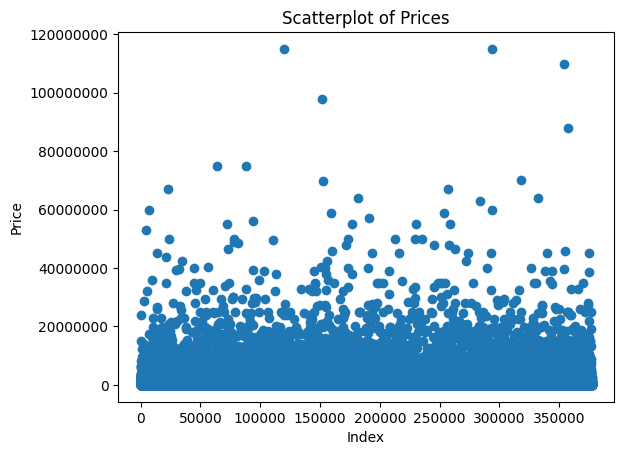

In [89]:
import matplotlib.pyplot as plt

plt.scatter(data.index, data['target'])
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Scatterplot of Prices')
plt.ticklabel_format(style='plain', axis='y')  # Отключение научной нотации
plt.show()

In [90]:
# Избавимся от крайне больших и маленьких значений
data = data[(data['target'] <= 4000000) & (data['target'] >= 20000)]

In [91]:
data['target']

0          418000.0
1          310000.0
2         2895000.0
3         2395000.0
5          209000.0
            ...    
377179     799000.0
377180    1249000.0
377181     674999.0
377182     528000.0
377184     204900.0
Name: target, Length: 313706, dtype: float64

Посмотрим на распределение target

# Столбец Year built

Преобразуем года в числовой формат, а так же удалим некорректные значения

In [92]:
data['Year built'].unique()

array(['2019', '1961', '2006', '1920', '1970', '1965', '2015', '1996',
       '1982', '2008', '1899', '2016', '1954', '1989', '2014', '1915', '',
       '1994', '1910', '1923', '1960', '1977', '1972', '1963', '1981',
       '1949', '1930', '1991', '2017', '2018', '1983', '1928', '1998',
       '1997', '1964', '1974', '1940', '1973', '1968', '1999', '1918',
       '2007', '1984', '1946', '2003', '2000', '1969', '2002', '1947',
       '1957', '1978', '1956', '1967', '1975', '1988', '1955', '1950',
       '1959', '2012', '1924', '1966', '2005', '1992', '2001', '1985',
       '1909', '1953', '1993', '1990', '1971', '1995', '2004', '1951',
       '1907', '1885', '1941', '1958', '2010', '1927', '1980', '1929',
       '1901', '1976', None, '1922', '1945', '1979', '2009', '1962',
       '1913', '2011', '1897', '1987', '2020', '1952', '1939', '1925',
       '2013', '1986', 'No Data', '1943', '1935', '1890', '1900', '1911',
       '1948', '1942', '1906', '1931', '1944', '1916', '1893', '1879',
 

In [93]:
# Преобразование в числовой формат
data['Year built'] = pd.to_numeric(data['Year built'], errors='coerce').astype('Int64', errors='ignore')

# Создаем маску для значений в нужном диапазоне
mask = (data['Year built'] >= 1700) & (data['Year built'] <= 2023)

# Заменяем значения вне этого диапазона на NaN
data.loc[~mask, 'Year built'] = np.nan

# Вычисляем среднее значение для 'Year built', пропуская NaN значения
mean_year = int(data['Year built'].mean(skipna=True))

# Заменяем NaN значения в 'Year built' на среднее значение
data['Year built'].fillna(mean_year, inplace=True)

In [94]:
mean_year

1979

# Столбец Remodeled year

Преобразуем года в числовой формат, а так же удалим некорректные значения

In [95]:
data['Remodeled year'].unique()

array(['', '1967', '2006', None, '2015', '1997', '2019', '1982', '2009',
       '2007', '1996', '1995', '1988', '1972', '1949', '1954', '1930',
       '2000', '1994', '1983', '2003', '1965', '1968', '1999', '2014',
       '2008', '2010', '2002', '1984', '1978', '1975', '1971', '1947',
       '1957', '1950', '2012', '1973', '1970', '2016', '1989', '1998',
       '1980', '1986', '2004', '2005', '1991', '1993', '2011', '2017',
       '1941', '2001', '1901', '1918', '1977', '1962', '1956', '2013',
       '1960', '1981', '1969', '1987', '1958', '1925', '1964', '1966',
       '1992', '1979', '1961', '1948', '1952', '1976', '1955', '1935',
       '1910', '1940', '2018', '1916', '1914', '1963', '1974', '1985',
       '1951', '1944', '1990', '1942', '1959', '1946', '1945', '1920',
       '1938', '1936', '0', '1939', '1915', '1928', '1927', '1923',
       '1934', '1899', '1953', '1931', '1937', '1912', '1906', '1929',
       '1932', '1905', '1921', '1924', '1907', '1911', '1900', '1889',
       

In [96]:
# Преобразование в числовой формат
data['Remodeled year'] = pd.to_numeric(data['Remodeled year'], errors='coerce').astype('Int64', errors='ignore')

# Создаем маску для значений в нужном диапазоне
mask = (data['Remodeled year'] >= 1700) & (data['Remodeled year'] <= 2023)

# Заменяем значения вне этого диапазона на NaN
data.loc[~mask, 'Remodeled year'] = np.nan

# Вычисляем среднее значение для 'Remodeled year', пропуская NaN значения
mean_year_remodeled = int(data['Remodeled year'].mean(skipna=True))

# Заменяем NaN значения в 'Remodeled year' на среднее значение
data['Remodeled year'].fillna(mean_year_remodeled, inplace=True)

In [97]:
data['Remodeled year'].unique()

<IntegerArray>
[1982, 1967, 2006, 2015, 1997, 2019, 2009, 2007, 1996, 1995,
 ...
 1885, 1870, 1887, 1853, 1888, 1800, 1738, 1876, 1874, 1862]
Length: 151, dtype: Int64

# Столбец Parking

Преобразуем значения в числа: если указано какое-либо место без конкретных числе, то ставим значение в 1, если есть число, то в это число, иначе в 0.

In [98]:
data['Parking'].unique()

array(['', 'Attached Garage', 'Detached Garage', ...,
       'Paved Driveway, Off Street, Detached Garage',
       'Driveway, Under Building', nan], dtype=object)

In [99]:
def extract_spaces(value):
    # Если значение является строкой, применяем регулярное выражение
    if isinstance(value, str):
        result = re.findall(r'\d+', value)
        if result:
            return int(result[0])
        elif value in ["", "No Data", "None"]:
            return 0
        else:
            return 1
    # Если это NaN или другой тип данных, возвращаем 0
    elif pd.isna(value):
        return 0
    else:
        return 1

data['Parking_Spaces'] = data['Parking'].apply(extract_spaces)

In [100]:
data['Parking_Spaces'].unique()

array([   0,    1,    2,    4,    3,   10,    7,    6,    8,    5,   21,
        888,    9,   20,   14,   60,   11,   32,   27,   55,  126,   12,
         16,   30, 5209,   50,   28,   93,   40,  153,   42,   18,   15,
         13,  140,  210,   89,   82,   24,  150,  110,   17,  238,  200,
         99,  353,  100,  131,   68,   37,   36,  112,  179,  162,   75,
         22,  105,   70,  348,   25, 2020,   19,  329,   23,  157,   29,
         56,  144,  331,  252,  108,  529,   79, 1016,  222,   43,  230,
         47,  344,  118])

In [101]:
# Удалить все значения, где указано более 20 парковочных мест
data['Parking_Spaces'] = data['Parking_Spaces'].apply(lambda x: np.nan if x > 20 else x)

In [102]:
# Удалить значения nan
data['Parking_Spaces'].fillna(value=0, inplace=True)

In [103]:
data['Parking_Spaces'].value_counts()

0.0     161891
1.0     114232
2.0      27639
3.0       4651
4.0       3032
6.0        800
5.0        686
8.0        231
7.0        161
10.0       119
9.0         77
12.0        64
20.0        29
11.0        27
14.0        16
15.0        14
16.0        12
13.0        10
18.0         8
17.0         5
19.0         2
Name: Parking_Spaces, dtype: int64

# Столбец lotsize

Береём исключительно числа

In [104]:
data['lotsize'].nunique()

33383

In [105]:
# Извлечение чисел
data['lotsize'] = data['lotsize'].str.replace(',', '').str.extract('(\d+)')
# Замена NaN на 0 и конвертация в int
data['lotsize'] = data['lotsize'].fillna(0).astype(np.int64)

In [106]:
data['lotsize'].nunique()

15255

# Столбец Price/sqft

Береём исключительно числа

In [107]:
data['Price/sqft'].unique()

array(['$144', '$159/sqft', '$965/sqft', ..., '$1141 / Sq. Ft.', '$2,592',
       nan], dtype=object)

In [108]:
# Извлечение чисел, удаление запятых и преобразование в int
data['Price/sqft'] = data['Price/sqft'].str.replace(',', '').str.extract('(\d+)').fillna(0).astype(np.int64)

In [109]:
data['Price/sqft'].unique()

array([ 144,  159,  965, ..., 4489, 2675, 1620])

Перед выделнием наиболее значимых факторов необходимо категориальные признаки представить в виде чисел (с помощью one-hot encoding)

In [110]:
data['status'].value_counts()

for sale                            173815
activated                           119852
new construction                      5782
foreclosed                            5043
under contract showing                3366
pre foreclosure                       3341
active auction                         797
contingency                            613
under contract backups                 301
insp inspection contingency            244
coming soon                            107
back on market                         104
pending take backups                    65
pending inspection                      49
active with offer                       44
active contingency                      42
contingency contract                    33
due diligence period                    26
pending - taking backups                17
listing extended                        10
active - auction                        10
under contract - show                    8
active option contract                   7
active opti

In [111]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 313706 entries, 0 to 377184
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   status                  313706 non-null  object 
 1   propertyType            297316 non-null  object 
 2   street                  313705 non-null  object 
 3   baths                   249765 non-null  object 
 4   fireplace               95663 non-null   object 
 5   city                    313684 non-null  object 
 6   schools                 313706 non-null  object 
 7   sqft                    313706 non-null  int64  
 8   zipcode                 313706 non-null  int64  
 9   beds                    313706 non-null  float64
 10  state                   313706 non-null  object 
 11  stories                 313706 non-null  int64  
 12  target                  313706 non-null  float64
 13  privatePool             313706 non-null  float64
 14  mlsId               

Переведем переменные в one-hot-encoding

In [112]:
status_dummies = pd.get_dummies(data['status'], prefix='status')
data = pd.concat([data, status_dummies], axis=1)
data.drop('status', axis=1, inplace=True)

In [113]:
propertyType_dummies = pd.get_dummies(data['propertyType'], prefix='propertyType')
data = pd.concat([data, propertyType_dummies], axis=1)
data.drop('propertyType', axis=1, inplace=True)

In [114]:
status_dummies = pd.get_dummies(data['state'], prefix='state')
data = pd.concat([data, status_dummies], axis=1)
data.drop('state', axis=1, inplace=True)

In [115]:
data.drop(['street', 'baths', 'schools', 'mlsId', 'fireplace',
           'Heating', 'Cooling', 'Parking', 'city', 'zipcode'
           ], axis=1, inplace=True)

In [116]:
data.columns

Index(['sqft', 'beds', 'stories', 'target', 'privatePool', 'cleaned_baths',
       'Year built', 'Remodeled year', 'lotsize', 'Price/sqft',
       ...
       'state_OS', 'state_PA', 'state_SC', 'state_TN', 'state_TX', 'state_UT',
       'state_VA', 'state_VT', 'state_WA', 'state_WI'],
      dtype='object', length=124)

# 2. Выделить наиболее значимые факторы, влияющие на стоимость недвижимости

In [117]:
data.corr()['target'].sort_values(ascending=False)

target               1.000000
cleaned_baths        0.377303
state_CA             0.207893
beds                 0.200607
state_NY             0.149492
                       ...   
num_schools         -0.053711
propertyType_land   -0.057810
state_MI            -0.064905
state_TX            -0.076907
state_OH            -0.093836
Name: target, Length: 124, dtype: float64

# 3. Построить модель для прогнозирования стоимости недвижимости

In [118]:
from sklearn.model_selection import train_test_split

# Предполагая, что 'target' это столбец со стоимостью недвижимости
X = data.drop('target', axis=1)
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [119]:
from sklearn.preprocessing import MinMaxScaler

# Инициализируем scaler
scaler = MinMaxScaler()

# Обучаем scaler на тренировочных данных и преобразуем их
X_train_scaled = scaler.fit_transform(X_train)

# Преобразуем тестовые данные с использованием того же scaler'а
X_test_scaled = scaler.transform(X_test)

In [120]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = model.predict(X_test)

# Оценка качества модели
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 197085065334.53653


In [121]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print(f'R-Squared: {r2}')

R-Squared: 0.3013117486053065


In [122]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 271411.42773342185


In [123]:
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 443942.63743701903


In [124]:
y_test

145279      84700.0
246649     214900.0
89562      249000.0
30855      429000.0
181006     109000.0
            ...    
224201     198000.0
252695     848500.0
218707     285000.0
78433      375000.0
261025    1780000.0
Name: target, Length: 62742, dtype: float64

In [125]:
y_pred

array([ 144020.6157288 ,  243774.06425157,  478161.17047043, ...,
        185766.28515206,  370559.43833884, 1611134.19839385])

Сохраним модель

In [126]:
from joblib import dump

# Сохранение модели в файл
dump(model, 'house_price_prediction.pkl')

['house_price_prediction.pkl']

# 4. Разработать небольшой веб-сервис, на вход которому поступают данные о некоторой выставленной на продажу недвижимости, а сервис прогнозирует его стоимость.

In [129]:
!pip install flask-ngrok
!pip install pyngrok==4.1.1
# !ngrok config add-authtoken 2WFLrRD2XFripsnoj0TcXWga2n7_6BmFKhpGsSPyv6YomSg4K
!ngrok authtoken 2WFLrRD2XFripsnoj0TcXWga2n7_6BmFKhpGsSPyv6YomSg4K

  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-4.1.1-py3-none-any.whl size=15963 sha256=1bc1f207afb83c116a416b760d892179da56058b0f8e6e06c8278f420015ada9
  Stored in directory: /root/.cache/pip/wheels/4c/7c/4c/632fba2ea8e88d8890102eb07bc922e1ca8fa14db5902c91a8
Successfully built pyngrok
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
from flask import Flask, jsonify, request
from joblib import load
from flask_ngrok import run_with_ngrok

app = Flask(__name__)
run_with_ngrok(app)

# Загрузка модели
model = load('house_price_prediction.pkl')

@app.route('/predict', methods=['POST'])
def predict():
    # Получение данных из запроса
    data = request.get_json(force=True)

    # Преобразуем в 2D массив
    data = [list(data.values())]

    # Предсказание
    prediction = model.predict(data)

    # Отправка результата обратно
    return jsonify(prediction[0])

if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://2722-35-201-184-41.ngrok-free.app
 * Traffic stats available on http://127.0.0.1:4040


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
INFO:werkzeug:127.0.0.1 - - [05/Oct/2023 19:18:36] "POST /predict HTTP/1.1" 200 -
